In [338]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table,Column,join
import time

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

import fitIR
import fitIR.models as models
import fitIR.analyse as analyse

import pickle

import h5py
import glob

from astropy.io import registry
from astropy.table.info import serialize_method_as

In [339]:
Table.read('../data/greybody_input_EN1_z_delta.fits')

help_id,f_pacs_green,ferr_pacs_green,f_pacs_red,ferr_pacs_red,f_spire_250,ferr_spire_250,f_spire_350,ferr_spire_350,f_spire_500,ferr_spire_500,redshift
,mJy,,mJy,,,,,,,,
bytes1728,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
HELP_J155620.810+545113.308,nan,nan,nan,nan,20906.186999999998,3980.425000000003,26584.743,4480.207000000002,28536.203,5316.896000000001,0.6999
HELP_J155622.752+545007.875,nan,nan,nan,nan,2092.5143,2675.7252,2062.2246,2575.2471,7125.304,4911.686,2.0693
HELP_J155628.426+544936.570,nan,nan,nan,nan,57610.979999999996,3814.3070000000007,51566.753,4147.212999999996,35905.814999999995,4875.199999999993,0.2276
HELP_J155631.071+545619.623,nan,nan,nan,nan,1423.2975999999999,1905.3827,975.4652,1316.3593999999998,3797.5717000000004,3478.171799999999,6.4312
HELP_J155633.728+545043.498,nan,nan,nan,nan,2945.7743,3704.1513999999997,2509.47,3254.6563,2519.6002000000003,3086.3507999999997,0.2609
HELP_J155642.969+550006.708,nan,nan,nan,nan,2926.415,3169.6553000000004,2065.978,2564.9299999999994,2364.6677,3590.5132999999996,0.7045
HELP_J155645.519+545325.942,500093.44,328516.12,493199.94,341882.88,5624.605,3197.91,6329.4177,3329.9092999999993,4587.751,4065.045,0.313
HELP_J155645.609+545744.746,492046.9,351186.4,488690.16,354101.53,1309.4773,1775.7573000000002,2644.618,2816.4429999999998,3526.915,3851.0957,0.3985


In [340]:
file_list = glob.glob('../data/*.pkl')
files = ['../data/lir_help_delta_{}.pkl'.format(n) for n in range(len(file_list))]

inputs = h5py.File('../../greybody_input_EN1.h5','r')

names = ['help_id','Temperature_l','Temperature','Temperature_u','redshift_l','redshift','redshift_u','log10lir_l','log10lir','log10lir_u']
output = np.array([])
batch_size = 50
empty_file = []

for n,file in enumerate(files):
    
    taskid = int(file.split('_')[-1].replace('.pkl',''))
    
    low = taskid*batch_size
    up = taskid*batch_size + (batch_size)
    ids = inputs['help_id'][low:up]
    
    if n%50==0:
        print(n)
    if os.path.getsize(file) == 0:
        print(file)
        empty_file.append(file)
        for n in range(50):
            output = np.append(output,[np.nan for n in range(len(names))])
        continue
    f = open(file,'rb')
    obj = pickle.load(f)
    #with open(file, "rb") as f:
    #    obj = pickle.load(f)
        
    for m,source in enumerate(obj):
        if type(source)!=fitIR.core.output:
            output = np.append(output,[np.nan for n in range(len(names))])
            continue
        a = analyse.analyser(source)

        P = a.P()
    
        tmp = []
        tmp.append(ids[m].decode())
        for key in P.keys():
            if key=='emissivity':
                continue
            tmp.append(P[key][1])
            tmp.append(P[key][2])
            tmp.append(P[key][3])
        output = np.append(output,tmp)

output = output.reshape(len(files)*batch_size,len(names))
tbl_out = Table()
for n in range(len(output[0])):
    col = Column(name=names[n],data=output[:,n])
    tbl_out.add_column(col)
    
mask = tbl_out['help_id']=='nan'
tbl_out = tbl_out[~mask]

0


In [341]:
tbl_out

help_id,Temperature_l,Temperature,Temperature_u,redshift_l,redshift,redshift_u,log10lir_l,log10lir,log10lir_u
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


with serialize_method_as(tbl_out, None):
    registry.write(tbl_out,'../data/EN1_ldust.fits',format='fits')

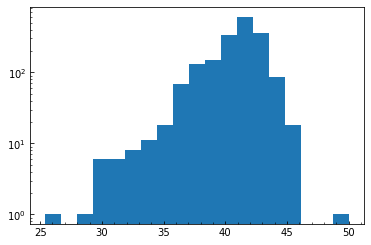

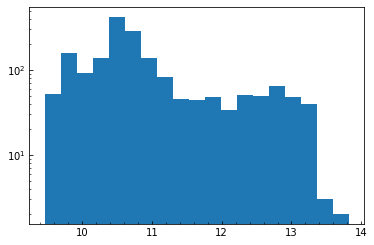

In [236]:
def plot_hist(table,colname,plot=True):
    y = table[colname].astype(float)
    mask = (~np.isnan(y)) & (np.isfinite(y))
    y = y[mask]
    
    max_bin = np.nanmax(y)
    min_bin = np.nanmin(y)
    bins = np.linspace(min_bin,max_bin,20)
    
    plt.hist(y,bins=bins,log=True)
    
    if plot==True:
        plt.show()

plot_hist(tbl_out,'Temperature')
plot_hist(tbl_out,'log10lir')

In [315]:
f = open(files[0],'rb')
obj = pickle.load(f)

In [331]:
obj[6][0].obs.fluxes

array([500.09344482, 493.19995117,   5.624605  ,   6.3294177 ,
         4.587751  ])

[0.01277465 0.0218274  3.257991   3.1839206  2.174615  ]
[0.01356039 0.02067491 2.919268   3.4948738  3.1027144 ]
T [20.78734521 23.19765741 38.17915871 55.73693401 58.83534821]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.636 1.636 1.636 1.636 1.636]
log10LIR [ 8.06657367  8.24552019  9.07642329  9.70331538 10.1416544 ]


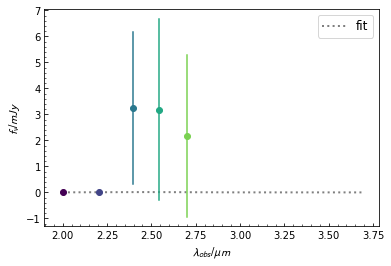

T
log10LIR


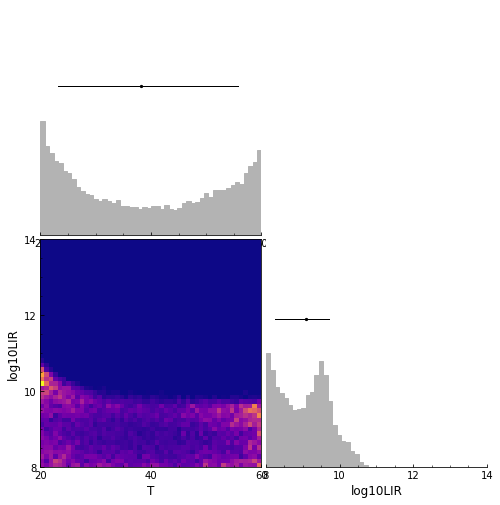

[0.01047315 0.021384   1.9321252  2.8272033  3.1617923 ]
[0.01387877 0.02065865 2.1416138  2.8680124  3.3156094 ]
T [20.8407249  23.32564455 38.02878372 55.08679757 58.6825065 ]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.0423 1.0423 1.0423 1.0423 1.0423]
log10LIR [8.04177919 8.15402103 8.66260119 9.1303412  9.30983044]


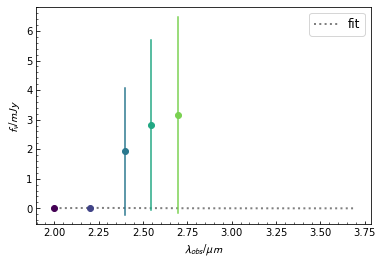

T
log10LIR


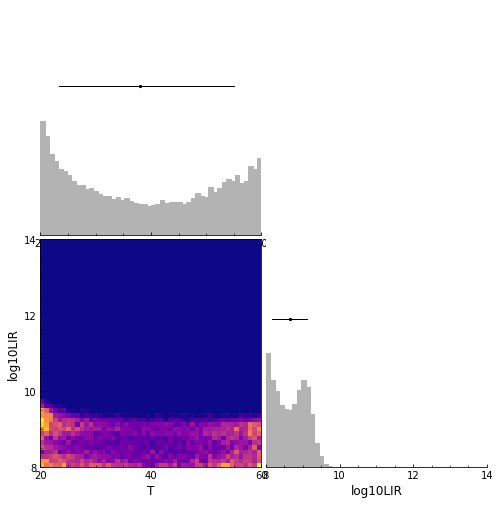

[0.0110054  0.01783543 2.0433407  1.1558114  5.645576  ]
[0.01482349 0.01980483 2.2197409  1.7237793  4.268462  ]
T [21.16972265 24.4886965  41.61313522 56.37708521 59.06338585]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.6681 0.6681 0.6681 0.6681 0.6681]
log10LIR [8.01975196 8.07358867 8.36947641 8.69269687 8.82199634]


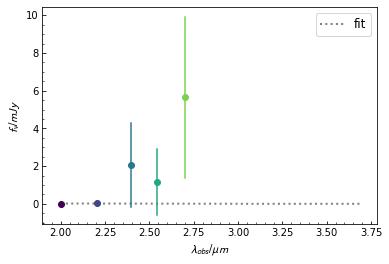

T
log10LIR


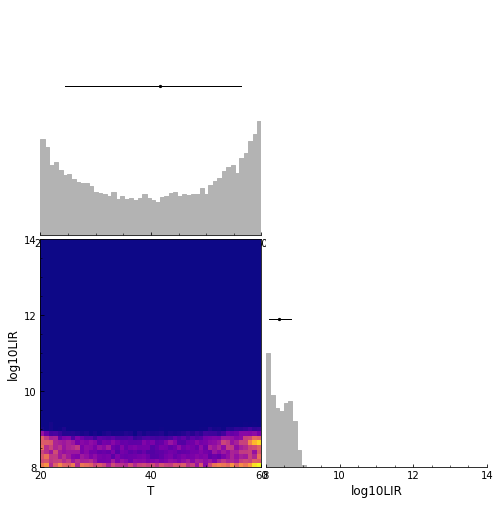

[0.00877496 0.01704885 1.7185881  2.8061998  2.3896468 ]
[0.01184475 0.0184387  2.0382083  3.1881242  3.0110957 ]
T [21.04113132 24.02719883 42.35219766 56.75224039 59.11863474]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.5221 0.5221 0.5221 0.5221 0.5221]
log10LIR [8.01223867 8.04712208 8.20185222 8.44762664 8.55738082]


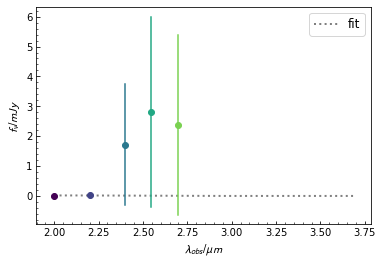

T
log10LIR


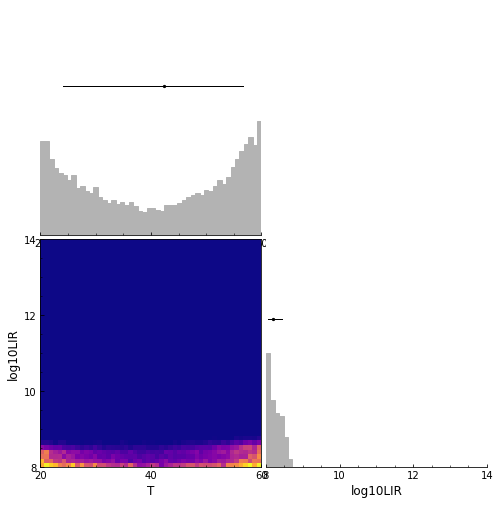

[0.48900303 0.50598061 1.1679511  1.0017145  2.5540583 ]
[0.35954016 0.35167167 1.3857043  1.4636333  3.1233207 ]
T [21.15642126 24.22541665 41.02567694 55.89104474 58.79901718]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.932 0.932 0.932 0.932 0.932]
log10LIR [ 8.10911658  8.42780285  9.88544794 10.37740518 10.51216185]


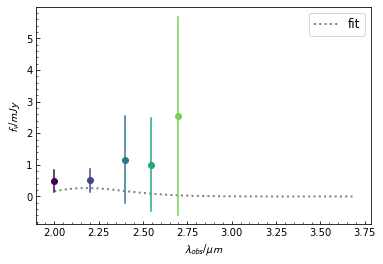

T
log10LIR


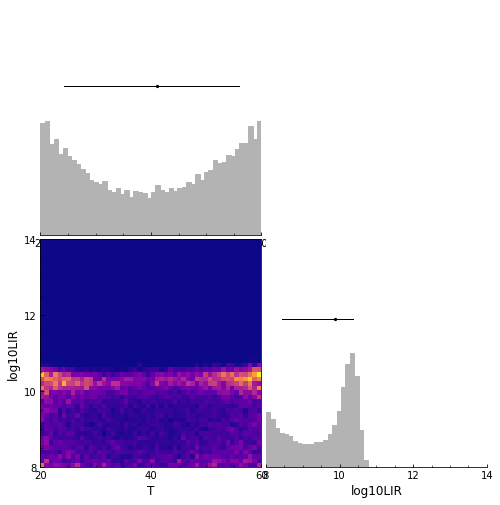

[6.33031735e-03 1.07921585e-02 4.10335200e+00 3.69974760e+00
 1.31148740e+01]
[0.00999985 0.01502362 3.0969725  3.4773804  6.3169295 ]
T [22.08378661 35.76641547 54.44238438 58.95164972 59.74013039]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.3454 0.3454 0.3454 0.3454 0.3454]
log10LIR [8.00264251 8.01099035 8.05911608 8.20166917 8.29388586]


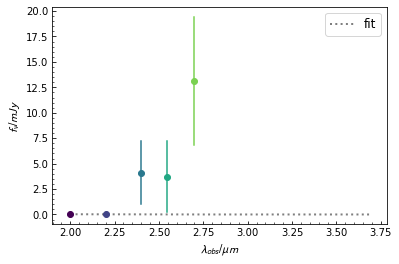

T
log10LIR


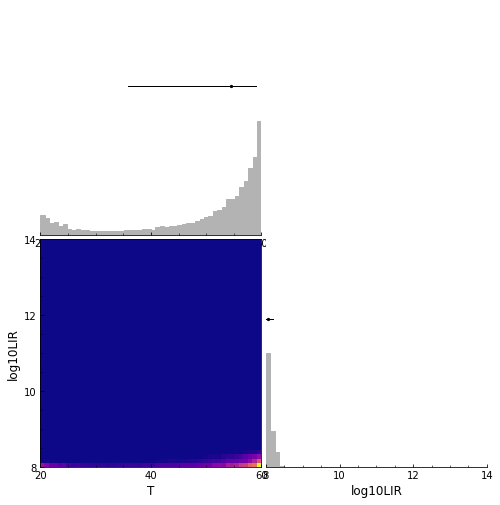

[0.02088766 0.02524385 2.964632   1.0273697  2.6733367 ]
[0.01741645 0.02061933 2.3345943  1.4700046  3.2176263 ]
T [20.95632165 23.81467836 36.75329951 54.9786858  58.60154209]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [4.7416 4.7416 4.7416 4.7416 4.7416]
log10LIR [ 8.10936277  8.48230636 10.33163076 11.86012498 12.25580259]


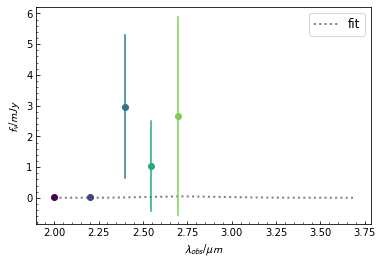

T
log10LIR


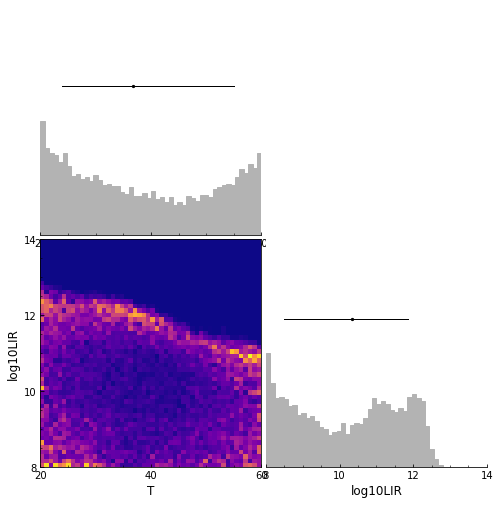

[0.50111645 0.49364457 3.2290516  1.21866    5.763314  ]
[0.34707907 0.34563801 2.5090934  1.6905578  3.297844  ]
T [21.1703039  23.93284606 39.25702658 55.78682478 58.92122953]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.5923 1.5923 1.5923 1.5923 1.5923]
log10LIR [ 8.1268956   8.49155368 10.3686377  10.9734526  11.16079837]


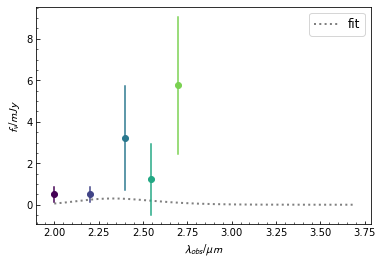

T
log10LIR


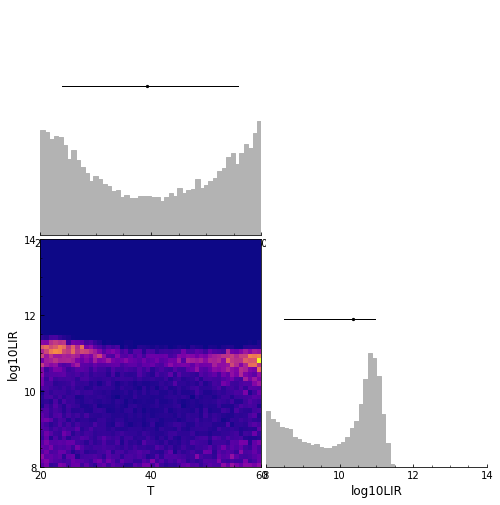

[0.00838095 0.01189414 2.4125419  6.1737084  3.4692283 ]
[0.01061014 0.01609157 2.9131921  4.6866196  4.8159022 ]
T [20.98666212 23.86424303 40.77931211 56.36506213 59.04732507]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.5884 0.5884 0.5884 0.5884 0.5884]
log10LIR [8.01382371 8.04967076 8.22871818 8.48226281 8.59937801]


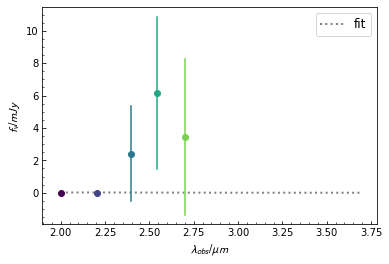

T
log10LIR


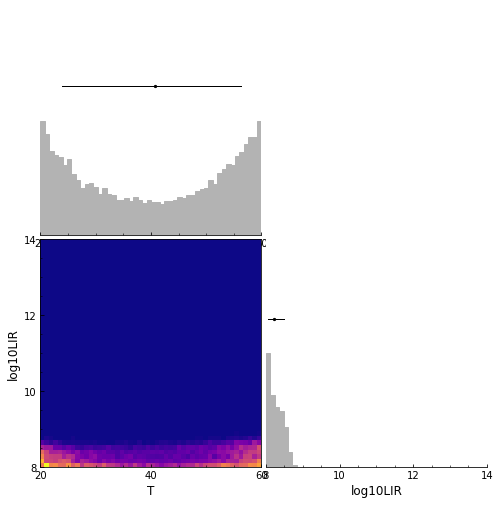

[0.00872797 0.0279918  1.8211714  2.3023748  2.2511191 ]
[0.01116015 0.0246024  2.2191406  2.9569092  3.0334509 ]
T [20.75004325 22.93075271 36.30629412 55.20201964 58.74298189]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.616 0.616 0.616 0.616 0.616]
log10LIR [8.01982446 8.07786642 8.34609467 8.64086459 8.76448078]


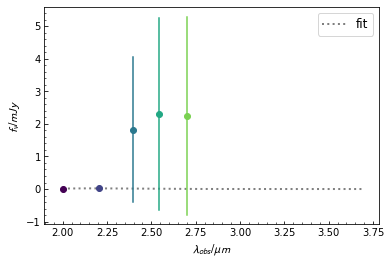

T
log10LIR


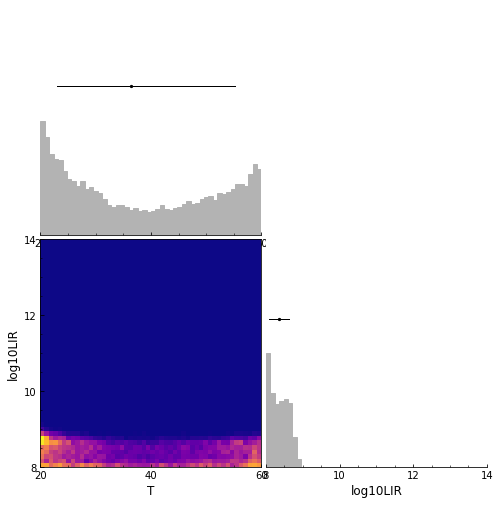

[7.97786471e-03 1.50153786e-02 1.13024610e+01 7.44594530e+00
 3.64297490e+00]
[0.01080623 0.01623713 2.876928   3.3797967  3.6421201 ]
T [20.92482626 23.72426588 39.61365368 55.70263109 58.79257818]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.6382 0.6382 0.6382 0.6382 0.6382]
log10LIR [8.01557282 8.06114358 8.29017275 8.56054319 8.67772006]


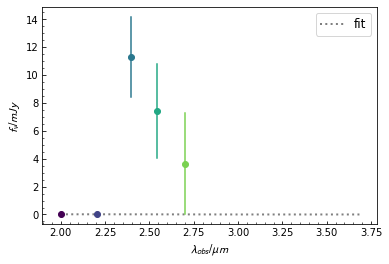

T
log10LIR


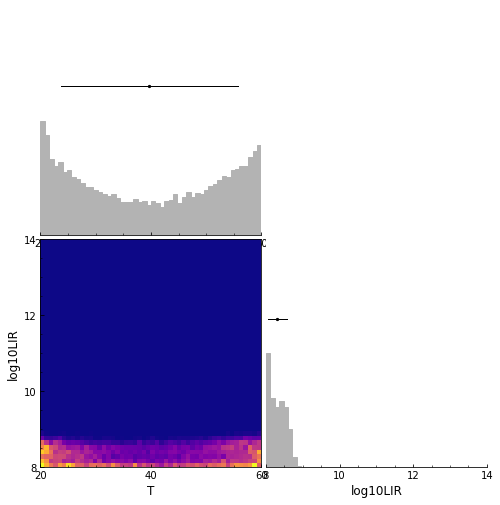

[0.5105716  0.50440657 1.5382227  1.032973   1.8355063 ]
[0.3432622  0.33158723 1.9212888  1.5343013  2.6439821 ]
T [21.43141304 24.99065389 41.15335661 55.82155751 58.77170081]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.2735 0.2735 0.2735 0.2735 0.2735]
log10LIR [8.0729321  8.26662606 8.90131146 9.30052284 9.49226211]


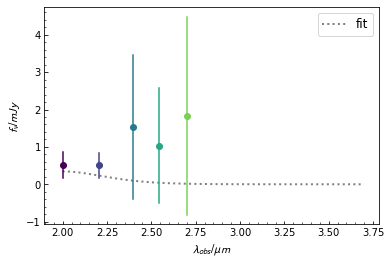

T
log10LIR


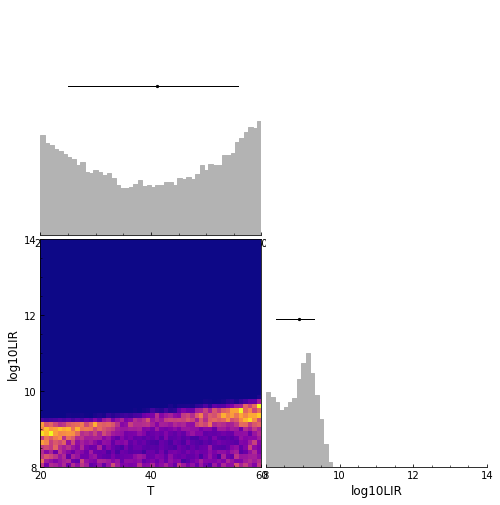

[0.48477927 0.49469122 6.551121   2.3899922  4.549881  ]
[0.34438902 0.35690448 3.670217   2.6573525  4.506315  ]
T [20.88944589 23.57858947 40.77407519 55.89678123 58.86396197]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.0162 1.0162 1.0162 1.0162 1.0162]
log10LIR [ 8.12825295  8.48096325  9.95092185 10.4831925  10.64080056]


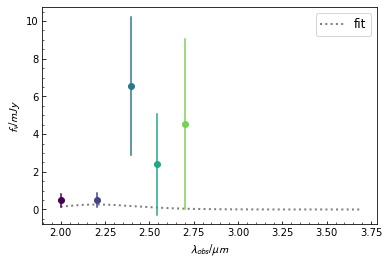

T
log10LIR


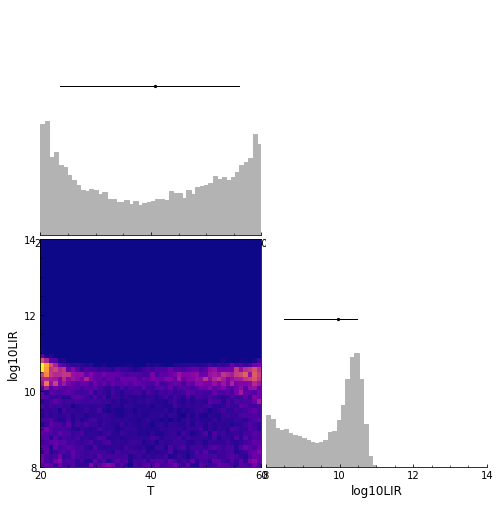

[0.50707704 0.50206381 2.2305737  2.7762854  8.718203  ]
[0.34404513 0.35806412 2.6628593  3.3180526  6.235156  ]
T [21.04060661 23.54697161 38.38218598 55.72450455 58.99303577]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.8082 1.8082 1.8082 1.8082 1.8082]
log10LIR [ 8.12311388  8.41673424 10.33092844 11.15493286 11.46166259]


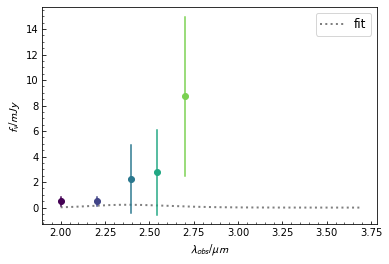

T
log10LIR


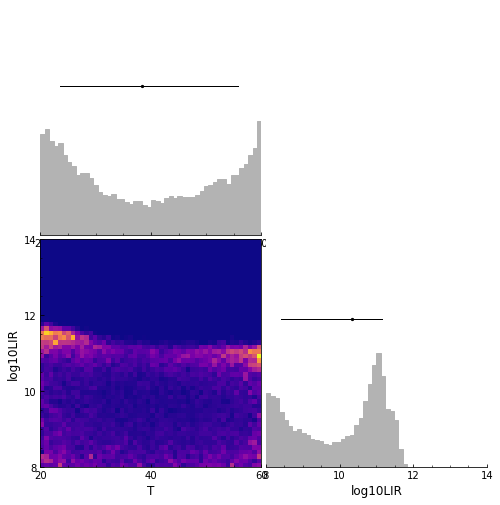

[0.50284493 0.49969444 2.284062   1.0667111  1.8322052 ]
[0.34268183 0.33964959 2.7316217  1.6275931  2.8038058 ]
T [21.27023003 24.81437169 42.18182897 56.39460854 59.01812096]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.2267 1.2267 1.2267 1.2267 1.2267]
log10LIR [ 8.11112788  8.42380527 10.02237436 10.64217867 10.78274251]


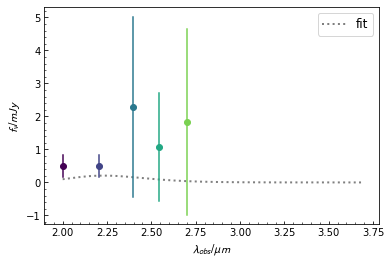

T
log10LIR


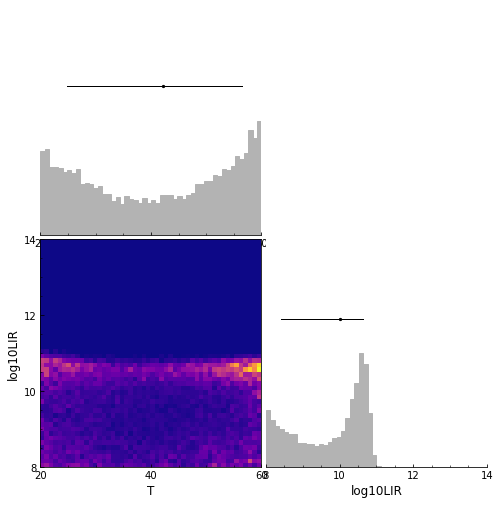

[0.0145977  0.00710145 1.2276003  1.0705671  1.1524382 ]
[0.01514894 0.01055165 1.5252697  1.4877854  1.9166445 ]
T [21.4984129  26.24529874 46.75624049 57.27529868 59.25560893]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.65 0.65 0.65 0.65 0.65]
log10LIR [8.01477229 8.05424916 8.2542005  8.57465739 8.73666017]


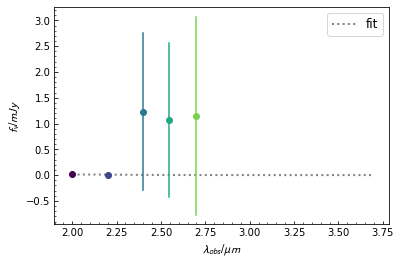

T
log10LIR


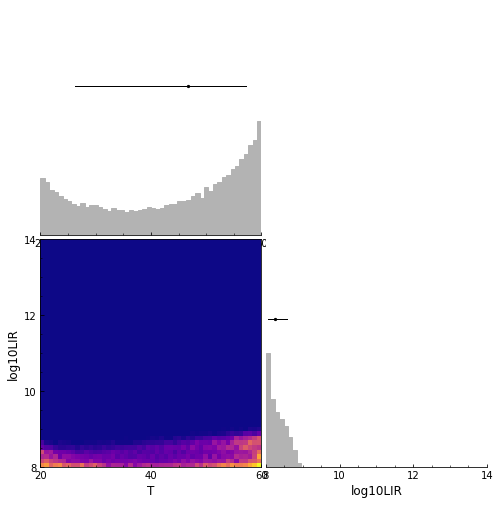

[0.02838025 0.03587695 1.4156339  1.1381742  2.3393288 ]
[0.01790593 0.02381151 2.1585891  1.5332988  3.1996169 ]
T [21.80033884 25.69183711 41.8018263  56.09964886 58.96482267]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.4779 0.4779 0.4779 0.4779 0.4779]
log10LIR [8.02871077 8.0950462  8.35807523 8.61217637 8.73483432]


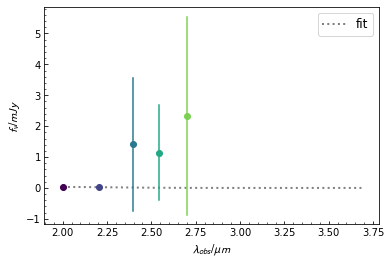

T
log10LIR


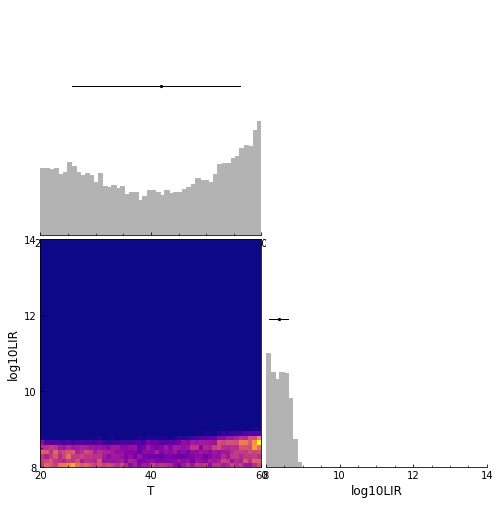

[0.49406284 0.50562173 5.4083195  2.7759953  1.5463325 ]
[0.3387844  0.35018075 3.2567225  2.9293322  2.280542  ]
T [20.91395243 23.72904762 41.67246925 56.09041487 58.94729874]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.104 1.104 1.104 1.104 1.104]
log10LIR [ 8.124554    8.45387167 10.03437159 10.57389393 10.74285895]


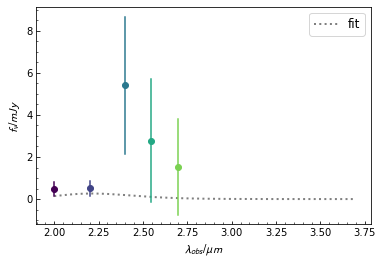

T
log10LIR


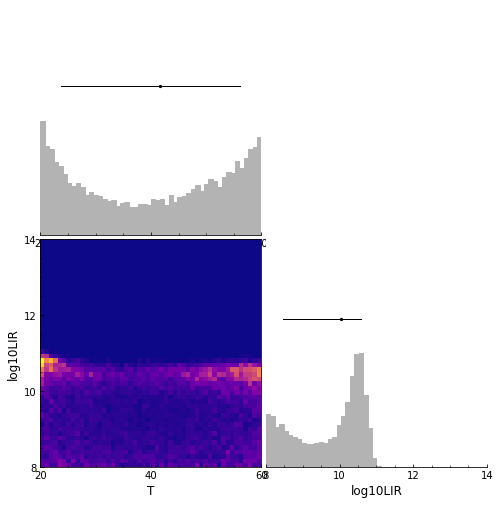

[0.49217999 0.5004077  3.4972286  3.3602018  2.4562888 ]
[0.33934063 0.33633468 2.6194564  2.9623556  3.0430432 ]
T [21.15920994 24.50713154 41.1674976  56.19678208 58.98658697]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.2586 0.2586 0.2586 0.2586 0.2586]
log10LIR [8.06845386 8.24622377 8.86433751 9.25550212 9.45156182]


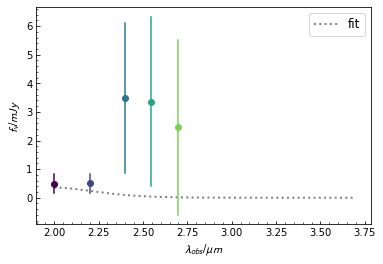

T
log10LIR


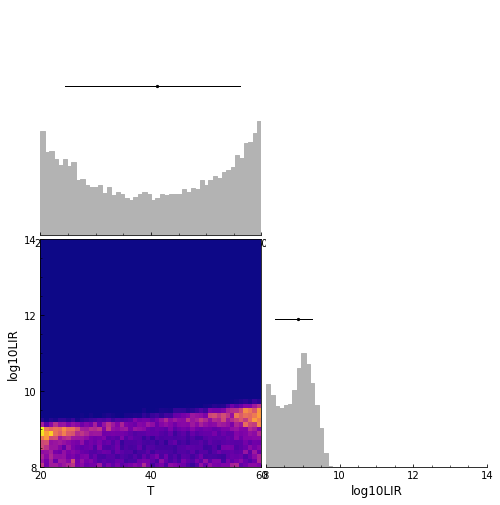

[0.48995209 0.48894379 2.1231873  1.373625   1.2708553 ]
[0.35090178 0.34162617 2.25366    2.0595375  1.8385874 ]
T [21.28650109 24.37939258 41.93726738 56.28966969 58.96265793]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.3321 1.3321 1.3321 1.3321 1.3321]
log10LIR [ 8.11087341  8.4458131  10.15434881 10.7318755  10.87726047]


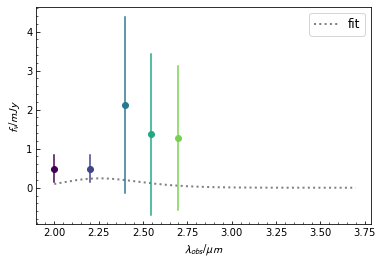

T
log10LIR


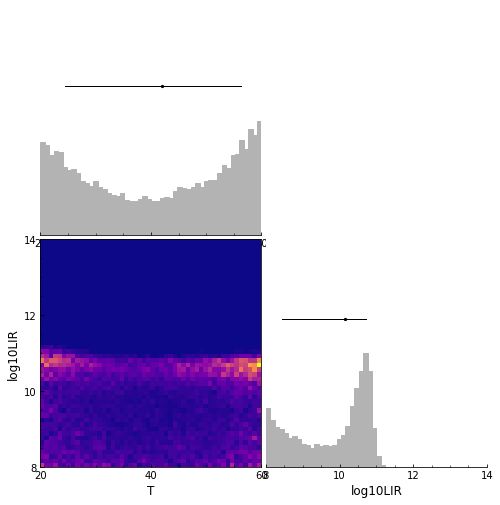

[0.01232235 0.01499804 6.050221   5.9046273  1.911178  ]
[0.01445525 0.01844827 3.977859   4.7001897  2.6037766 ]
T [20.56373959 22.37169322 35.22492519 55.18199027 58.81286646]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.9983 1.9983 1.9983 1.9983 1.9983]
log10LIR [ 8.06783017  8.24295757  9.14442134 10.01551892 10.63833601]


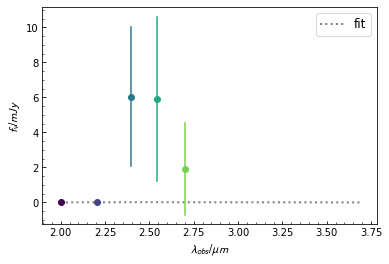

T
log10LIR


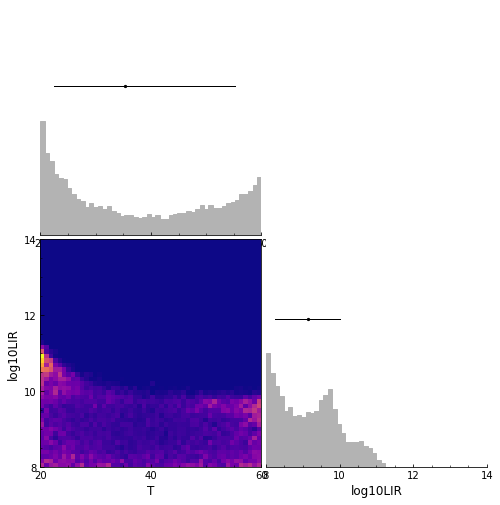

AttributeError: 'float' object has no attribute 'obs'

In [342]:
for num in range(50):
    print(obj[num][0].obs.fluxes)
    print(obj[num][0].obs.errors)
    a = analyse.analyser(obj[num][0])

    P = a.P() # returns 5th, 16th, 50th, 84th, 95th percentile 
    for p in P.keys(): print(p, P[p])

    a.sed_plot()
    a.triangle_plot()

In [282]:
file_list = glob.glob('../data/*.pkl')
files = ['../data/lir_help_{}.pkl'.format(n) for n in range(len(file_list))]

names = ['help_id','Temperature_l','Temperature','Temperature_u','redshift_l','redshift','redshift_u','log10lir_l','log10lir','log10lir_u']
output = []
empty_file = []

for n,file in enumerate(files):
    if n%50==0:
        print(n)
    if os.path.getsize(file) == 0:
        print(file)
        empty_file.append(file)
        for n in range(50):
            output.append([np.nan for n in range(len(names))])
        continue
    f = open(file,'rb')
    obj = pickle.load(f)
    #with open(file, "rb") as f:
    #    obj = pickle.load(f)
        
    for m,source in enumerate(obj):
        if type(source[0])!=fitIR.core.output:
            output.append([np.nan for n in range(len(names))])
            continue
        a = analyse.analyser(source[0])

        P = a.P()
    
        tmp = []
        tmp.append(ids[m].decode())
        for key in P.keys():
            if key=='emissivity':
                continue
            tmp.append(P[key][1])
            tmp.append(P[key][2])
            tmp.append(P[key][3])
        output.append(tmp)

output = np.array(output)
tbl_out_delta = Table()
for n in range(len(output[0])):
    col = Column(name=names[n],data=output[:,n])
    tbl_out_delta.add_column(col)
    
mask = tbl_out_delta['help_id']=='nan'
tbl_out_delta = tbl_out_delta[~mask]

for name in tbl_out_delta.colnames:
    try:
        tbl_out_delta[name] = tbl_out_delta[name].astype(float)
    except:()

0
../data/lir_help_0.pkl
../data/lir_help_1.pkl
../data/lir_help_6.pkl
../data/lir_help_8.pkl
../data/lir_help_12.pkl
../data/lir_help_28.pkl
../data/lir_help_31.pkl
../data/lir_help_37.pkl


In [283]:
tbl_out_delta

help_id,Temperature_l,Temperature,Temperature_u,redshift_l,redshift,redshift_u,log10lir_l,log10lir,log10lir_u
str32,float64,float64,float64,float64,float64,float64,float64,float64,float64
HELP_J155855.670+544412.555,24.411416636629756,39.636973424508255,55.45836396332839,0.3008,0.3008,0.3008,8.260547940287898,8.942091627727088,9.354928653167264
HELP_J155855.725+550955.214,24.69717309564716,39.446815853222816,55.50128488402309,0.3719,0.3719,0.3719,8.272632097759558,9.102756166789817,9.531446354904729
HELP_J155855.736+545319.430,24.742338376981387,40.66209324291592,56.12268831810249,0.4252,0.4252,0.4252,8.349235315097777,9.264000266393495,9.657439659555843
HELP_J155855.816+544103.590,24.939124758214415,41.53470299711789,55.77031886107805,0.2443,0.2443,0.2443,8.238029375691273,8.809262578010705,9.198271931010336
HELP_J155855.824+544738.511,23.931037420655628,40.61996960794674,55.88982783591153,0.9258,0.9258,0.9258,8.357114315992646,9.766164708826418,10.380073446178205
HELP_J155855.852+545748.813,24.649380033614584,41.543065980204794,55.98594128774267,0.5968,0.5968,0.5968,8.295981815446297,9.402872439826655,9.929375563355336
HELP_J155855.919+550538.906,24.46713394680281,40.907610960586766,55.796857675255914,0.7674,0.7674,0.7674,8.36500276313981,9.689027156325665,10.170366906189587
HELP_J155855.955+551211.288,24.123868345741176,40.799590508272345,55.720644296991765,0.7384,0.7384,0.7384,8.366019693427942,9.66194661724732,10.155580281239079
HELP_J155856.004+551728.951,24.501127394997585,41.33448662422231,56.17993736231563,0.8403,0.8403,0.8403,8.354584695553498,9.684231679600385,10.25211406182993


In [309]:
a.obs.errors*1000

array([  15.1489377 ,   10.55165008, 1525.2697    , 1487.7854    ,
       1916.6445    ])

In [310]:
a.obs.fluxes*1000

array([  14.59770091,    7.10145477, 1227.6003    , 1070.5671    ,
       1152.4382    ])

T [21.36288031 25.79967078 46.86744839 57.44192495 59.29819444]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.65 0.65 0.65 0.65 0.65]
log10LIR [8.01772645 8.06419407 8.26259781 8.57746    8.73849218]


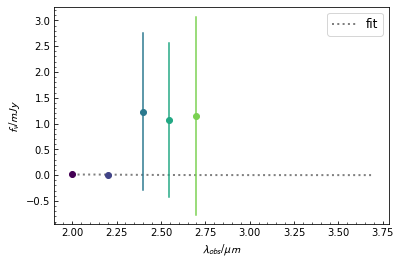

T
log10LIR


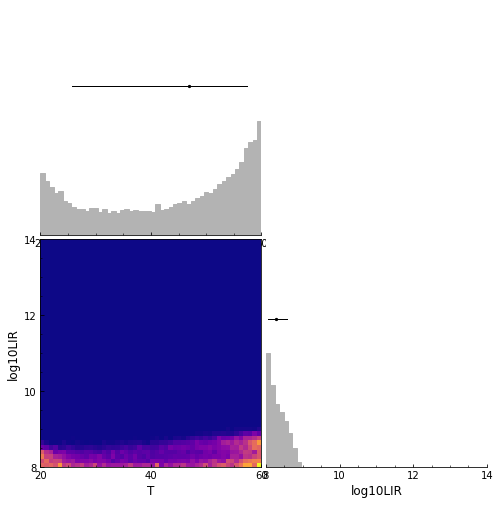

In [305]:
f = open(files[-1],'rb')
obj = pickle.load(f)

a = analyse.analyser(obj[15][0])

P = a.P() # returns 5th, 16th, 50th, 84th, 95th percentile 
for p in P.keys(): print(p, P[p])

a.sed_plot()
a.triangle_plot()

In [295]:
obj[0]

[<fitIR.core.output at 0x7fffd4ee24a8>, b'HELP_J155912.612+545539.755']